Import dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
data_raw = pd.read_csv("F:\Breast Cancer Survival Predicion\METABRIC_RNA_Data.csv")
data = data_raw.copy()
row, col = data.shape
data.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2072\1756772075.py:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv("F:\Breast Cancer Survival Predicion\METABRIC_RNA_Data.csv")


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# separating index and label column
data_index = data['patient_id']
data_label = data['overall_survival']
data = data.drop(columns=['patient_id','overall_survival'])

Data Preprocessing

In [4]:
# handling missing values 
missing_value = data.isnull()
print(missing_value.sum())

age_at_diagnosis           0
type_of_breast_surgery    22
cancer_type                0
cancer_type_detailed      15
cellularity               54
                          ..
hras_mut                   0
prps2_mut                  0
smarcb1_mut                0
stmn2_mut                  0
siah1_mut                  0
Length: 691, dtype: int64


In [5]:
# drop with missing value percentage 30%
threshold = row * 0.3
data.dropna(thresh=threshold, axis=1, inplace=True)

In [6]:
# return data with only with missing values
missing_columns = data.columns[data.isnull().sum() > 0]
data_missing_value = data[missing_columns]
data_missing_value.isnull().sum()

type_of_breast_surgery             22
cancer_type_detailed               15
cellularity                        54
er_status_measured_by_ihc          30
neoplasm_histologic_grade          72
tumor_other_histologic_subtype     15
primary_tumor_laterality          106
mutation_count                     45
oncotree_code                      15
3-gene_classifier_subtype         204
tumor_size                         20
tumor_stage                       501
death_from_cancer                   1
dtype: int64

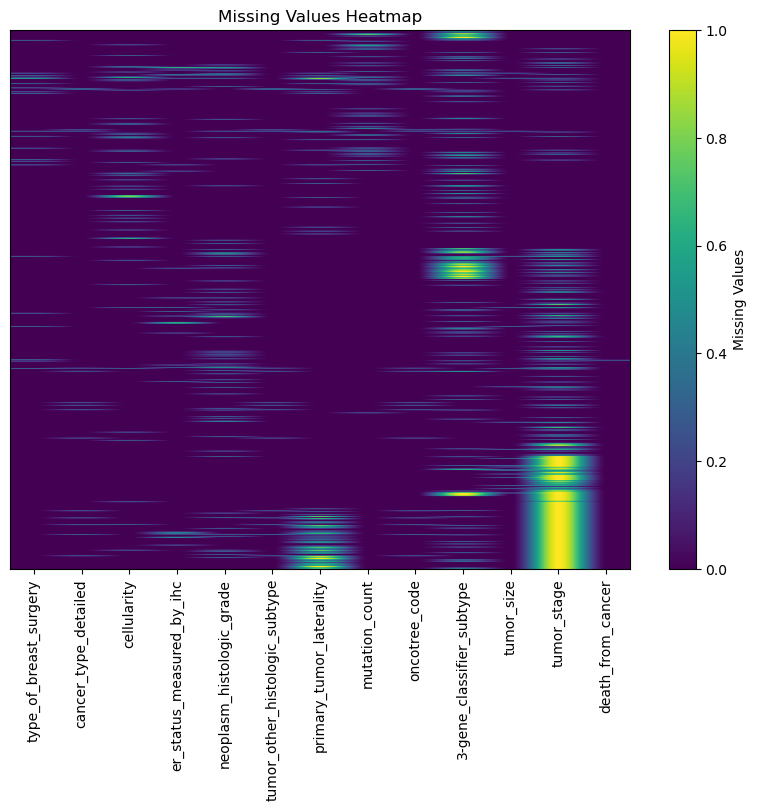

In [7]:
# missing value visualize with heatmap
plt.figure(figsize=(10, 7))
plt.imshow(data_missing_value.isnull(), cmap='viridis', aspect='auto')
plt.title('Missing Values Heatmap')
plt.colorbar(label='Missing Values')
plt.xticks(range(len(data_missing_value.columns)), data_missing_value.columns, rotation=90)
plt.yticks([])
plt.show()

In [8]:
# separating numerical and categorical columns to handle missing value
categorical_missing = data_missing_value[data_missing_value.select_dtypes(include=['object', 'category']).columns]
numerical_missing = data_missing_value[data_missing_value.select_dtypes(include=['int64', 'float64']).columns]

In [9]:
# handling the missing value with mode of that column for >>>>>>>>>>>>> categorical columns
# replacing the missing with most numbers of occurence of value in that column
for col in categorical_missing:
    if data[col].isnull().any():
        most_frequent = data[col].mode()[0]
        data[col].fillna(most_frequent, inplace=True)

# handling the missing value with mean of that column for >>>>>>>>>>>>>> numerical columns
# replacing the missing with mean in that column
for col in numerical_missing:
    if data[col].isnull().any():
        mean_value = data[col].mean()
        data[col].fillna(mean_value, inplace=True)

In [10]:
data.isnull().sum()

age_at_diagnosis          0
type_of_breast_surgery    0
cancer_type               0
cancer_type_detailed      0
cellularity               0
                         ..
hras_mut                  0
prps2_mut                 0
smarcb1_mut               0
stmn2_mut                 0
siah1_mut                 0
Length: 691, dtype: int64

Data Exploratory

In [11]:
# separating categorical data and numerical data
main_features = data[data.columns[:28]]
categorical_data = main_features[main_features.select_dtypes(include=['object', 'category']).columns]
numerical_data = main_features[main_features.select_dtypes(include=['int64', 'float64']).columns]

# scaling the numerical values
scaler = StandardScaler()
numerical_data = scaler.fit_transform(numerical_data)
numerical_data = pd.DataFrame(numerical_data, columns=main_features.select_dtypes(include=['int64', 'float64']).columns)

In [12]:
# summary (mean, max, min, etc) of numerical columns  
numerical_summary = numerical_data.describe()
numerical_summary

,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,radio_therapy,tumor_size,tumor_stage
count,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03
mean,1.492737e-16,-1.492737e-17,-1.194189e-16,5.019328e-16,-1.194189e-16,3.731842e-18,-1.791284e-16,-3.060111e-16,-3.545250e-17,2.985474e-17,1.250167e-16,1.367953e-16
std,1.000263e+00,1.000263e+00,1.000263e+00,1.000263e+00,1.000263e+00,1.000263e+00,1.000263e+00,1.000263e+00,1.000263e+00,1.000263e+00,1.000263e+00,1.000263e+00
min,-3.017814e+00,-5.124446e-01,-1.338368e+00,-2.219279e+00,-1.268156e+00,-4.908407e-01,-1.171654e+00,-2.650797e+00,-1.639557e+00,-1.217538e+00,-1.673973e+00,-3.243248e+00
25%,-7.485030e-01,-5.124446e-01,-1.338368e+00,-6.519238e-01,-1.268156e+00,-4.908407e-01,-6.728323e-01,-8.626345e-01,-8.425222e-01,-1.217538e+00,-6.127640e-01,-1.390529e+00
50%,5.263433e-02,-5.124446e-01,2.899085e-01,6.960454e-16,7.885466e-01,-4.908407e-01,-1.740107e-01,7.849515e-03,-1.245465e-01,8.213296e-01,-2.148104e-01,0.000000e+00
75%,7.325799e-01,-5.124446e-01,2.899085e-01,9.154310e-01,7.885466e-01,-5.150480e-04,3.248110e-01,8.803000e-01,7.809218e-01,8.213296e-01,2.494687e-01,4.621892e-01
max,2.713073e+00,1.951430e+00,1.918185e+00,9.154310e-01,7.885466e-01,1.054149e+01,1.853180e+01,2.033735e+00,3.014891e+00,8.213296e-01,1.033096e+01,4.167626e+00


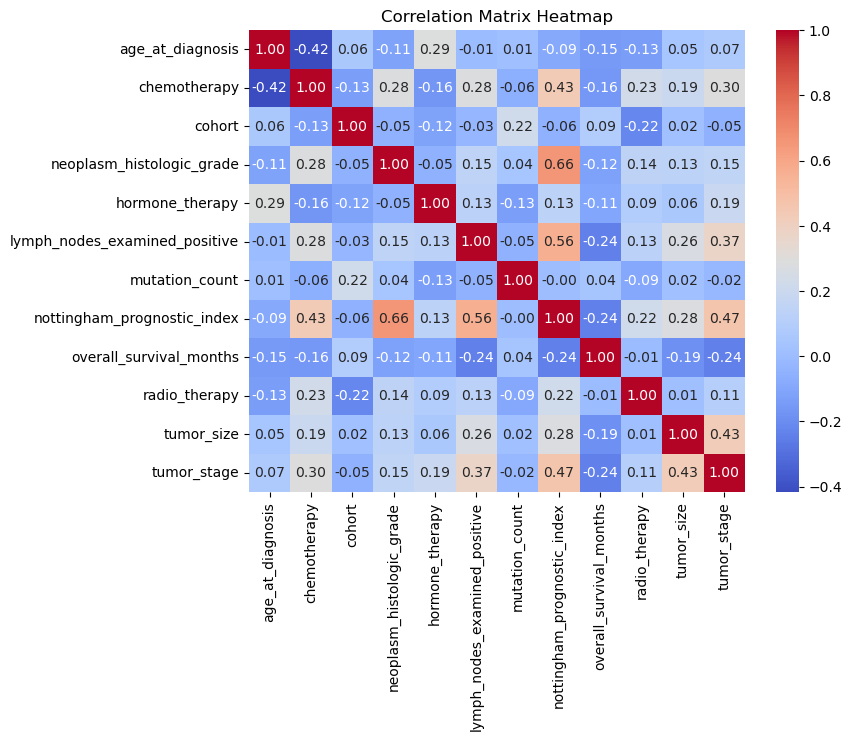

In [13]:
# correlation analysis to understand the relationship
corr_matrix = numerical_data.corr()

plt.figure(figsize=(8, 6))                                         #heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

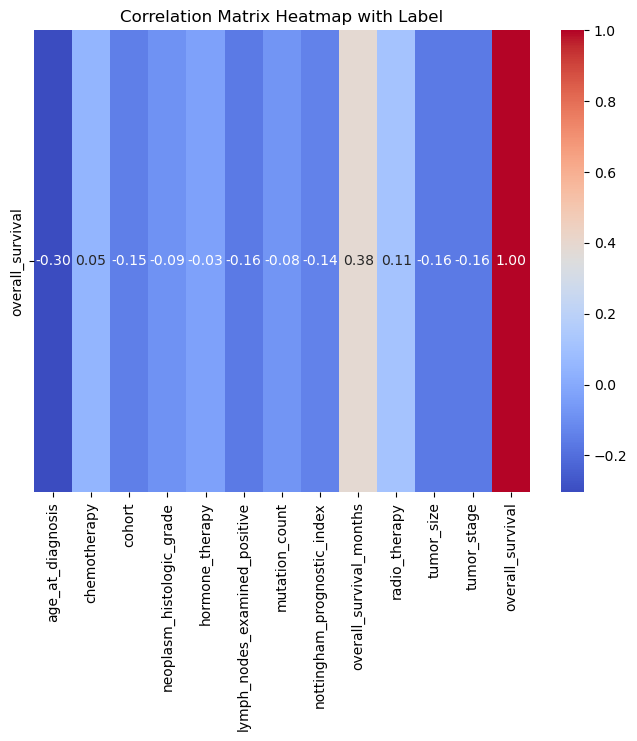

In [14]:
# correlation with outcome
numerical_data_outcome = numerical_data.join(data_label)
corr_with_label = numerical_data_outcome.corr()['overall_survival']
corr_with_label = pd.DataFrame(corr_with_label).T

plt.figure(figsize=(8, 6))                                         #heatmap
sns.heatmap(corr_with_label, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix Heatmap with Label')
plt.show()

In [15]:
# Calculating IQR and detecting outliers for each numerical column
outlier_summary = {}

for col in main_features.select_dtypes(include=['int64', 'float64']).columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    outlier_summary[col] = len(outliers)

outlier_summary_sorted = dict(sorted(outlier_summary.items(), key=lambda item: item[1], reverse=True))
list(outlier_summary_sorted.items())[:5]

[('chemotherapy', 396),
 ('lymph_nodes_examined_positive', 210),
 ('tumor_size', 142),
 ('mutation_count', 62),
 ('tumor_stage', 9)]

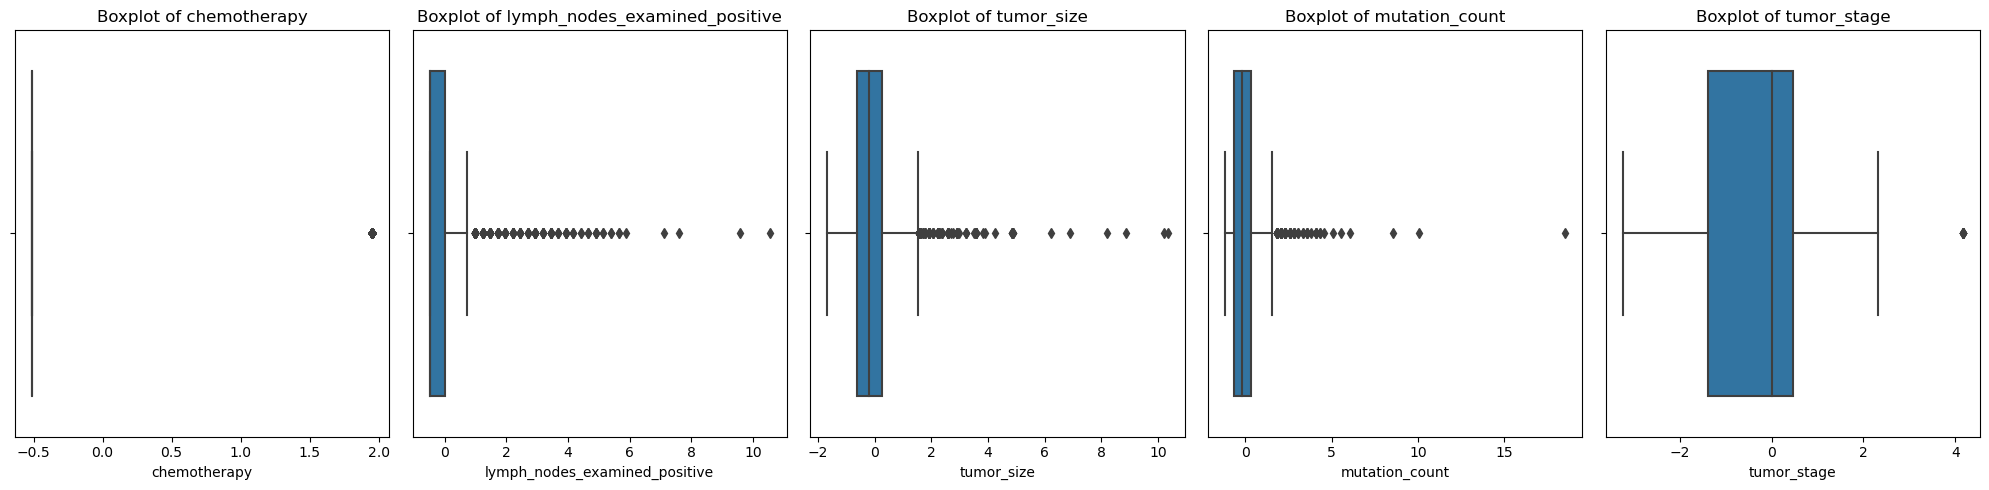

In [16]:
# visualize the outline from the columns from list(outlier_summary_sorted)
top_outlier_columns = []
for col, num in list(outlier_summary_sorted.items()):
    if num > 5:
        top_outlier_columns.append(col)

fig, axes = plt.subplots(nrows=1, ncols=len(top_outlier_columns), figsize=(20, 5))
for i, col in enumerate(top_outlier_columns):
    sns.boxplot(x=numerical_data[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [17]:
# though there is too much outliner, still 'camotherapy' as a vital role for prediction
# cube square to avoid outliner effect
for col in top_outlier_columns:
    numerical_data[f'{col}'] = np.cbrt(numerical_data[col])
numerical_data

,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,radio_therapy,tumor_size,tumor_stage
0,1.122359,-0.800231,-1.338368,0.915431,0.788547,1.251633,-0.000006,1.757557,0.201518,0.821330,-0.655097,0.773167
1,-1.379317,-0.800231,-1.338368,0.915431,0.788547,-0.788824,-0.973379,-0.011378,-0.530544,0.821330,-1.025048,-1.116161
2,-0.941562,1.249638,-1.338368,-0.651924,0.788547,-0.626309,-0.973379,-0.002638,0.505525,-1.217538,-0.906705,0.773167
3,-1.033275,1.249638,-1.338368,-0.651924,0.788547,0.625432,-1.054225,0.014841,0.521686,0.821330,-0.434729,0.773167
4,1.224091,1.249638,-1.338368,0.915431,0.788547,1.137150,-0.973379,1.789021,-1.097499,0.821330,0.970018,0.773167
...,...,...,...,...,...,...,...,...,...,...,...,...
1899,-1.386253,-0.800231,1.104047,0.915431,0.788547,-0.626309,-0.750915,0.888821,0.940132,0.821330,-0.434729,0.000000
1900,-1.403208,-0.800231,1.104047,0.915431,-1.268156,-0.626309,0.422465,0.880081,-1.053383,0.821330,-0.745176,0.000000
1901,0.139723,-0.800231,1.104047,0.915431,0.788547,2.192640,-0.750915,1.762801,0.666264,0.821330,-0.434729,0.000000
1902,0.005622,-0.800231,1.104047,-0.651924,0.788547,1.348304,1.323840,0.888821,-0.509578,-1.217538,-0.434729,0.000000


In [18]:
# explore of secondary features numerical columns
seconday_numerical = data[data.columns[29:518]]
seconday_numerical.describe()

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
count,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1904.000000,...,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03
mean,-6.302521e-07,-4.201681e-07,3.676471e-07,-8.928571e-07,6.302521e-07,-2.100840e-07,0.000002,7.463684e-18,-3.676471e-07,-0.000001,...,4.726891e-07,-3.676471e-07,-9.453782e-07,-1.050420e-07,-0.000002,3.676471e-07,4.726891e-07,7.878151e-07,0.000000,3.731842e-18
std,1.000262e+00,1.000262e+00,1.000263e+00,1.000263e+00,1.000263e+00,1.000262e+00,1.000263,1.000262e+00,1.000263e+00,1.000262,...,1.000263e+00,1.000262e+00,1.000262e+00,1.000263e+00,1.000262,1.000264e+00,1.000262e+00,1.000263e+00,1.000262,1.000262e+00
min,-2.444400e+00,-2.783500e+00,-4.384600e+00,-5.932800e+00,-2.481200e+00,-3.170500e+00,-3.323700,-2.688700e+00,-3.689800e+00,-2.968600,...,-2.120800e+00,-3.364800e+00,-2.719400e+00,-4.982700e+00,-2.981700,-3.833300e+00,-3.609300e+00,-1.166900e+00,-2.112600,-1.051600e+00
25%,-7.198500e-01,-6.994750e-01,-6.798250e-01,-5.586500e-01,-6.661500e-01,-6.602250e-01,-0.458600,-7.385500e-01,-6.667750e-01,-0.683925,...,-6.188500e-01,-6.104750e-01,-6.741750e-01,-6.136750e-01,-0.632900,-6.664750e-01,-7.102000e-01,-5.058250e-01,-0.476200,-7.260000e-01
50%,-1.244500e-01,-5.820000e-02,-2.210000e-02,1.098500e-01,-3.010000e-02,-4.200000e-03,0.115550,-1.311000e-01,-1.445000e-02,-0.054800,...,-2.456500e-01,-4.690000e-02,-1.422500e-01,-5.175000e-02,-0.026650,7.000000e-04,-2.980000e-02,-2.885500e-01,-0.133400,-4.248000e-01
75%,5.532250e-01,6.290000e-01,6.400000e-01,6.426250e-01,6.447500e-01,6.901500e-01,0.649800,5.431250e-01,6.387250e-01,0.668925,...,3.306000e-01,5.144500e-01,5.146000e-01,5.787750e-01,0.590350,6.429000e-01,5.957250e-01,6.022500e-02,0.270375,4.284000e-01
max,4.554200e+00,3.737900e+00,4.615000e+00,3.254100e+00,4.289800e+00,3.824200e+00,2.820900,4.538200e+00,5.371300e+00,6.178600,...,6.534900e+00,1.027030e+01,6.329000e+00,4.571300e+00,12.742300,3.938800e+00,3.833400e+00,1.088490e+01,12.643900,3.284400e+00


In [19]:
# scale the seconday_features_numerical data
scaler = StandardScaler()
seconday_features_numerical = scaler.fit_transform(seconday_numerical)
seconday_features_numerical = pd.DataFrame(seconday_features_numerical, columns=seconday_numerical.columns)

In [20]:
# Calculating IQR and detecting outliers for each secondary numerical column
outlier_summary = {}

for col in seconday_features_numerical.select_dtypes(include=['int64', 'float64']).columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    outlier_summary[col] = len(outliers)

outlier_summary_sorted = dict(sorted(outlier_summary.items(), key=lambda item: item[1], reverse=True))
list(outlier_summary_sorted.items())[:5]

[('gldc', 230),
 ('erbb2', 224),
 ('ttyh1', 213),
 ('ugt2b15', 208),
 ('muc16', 202)]

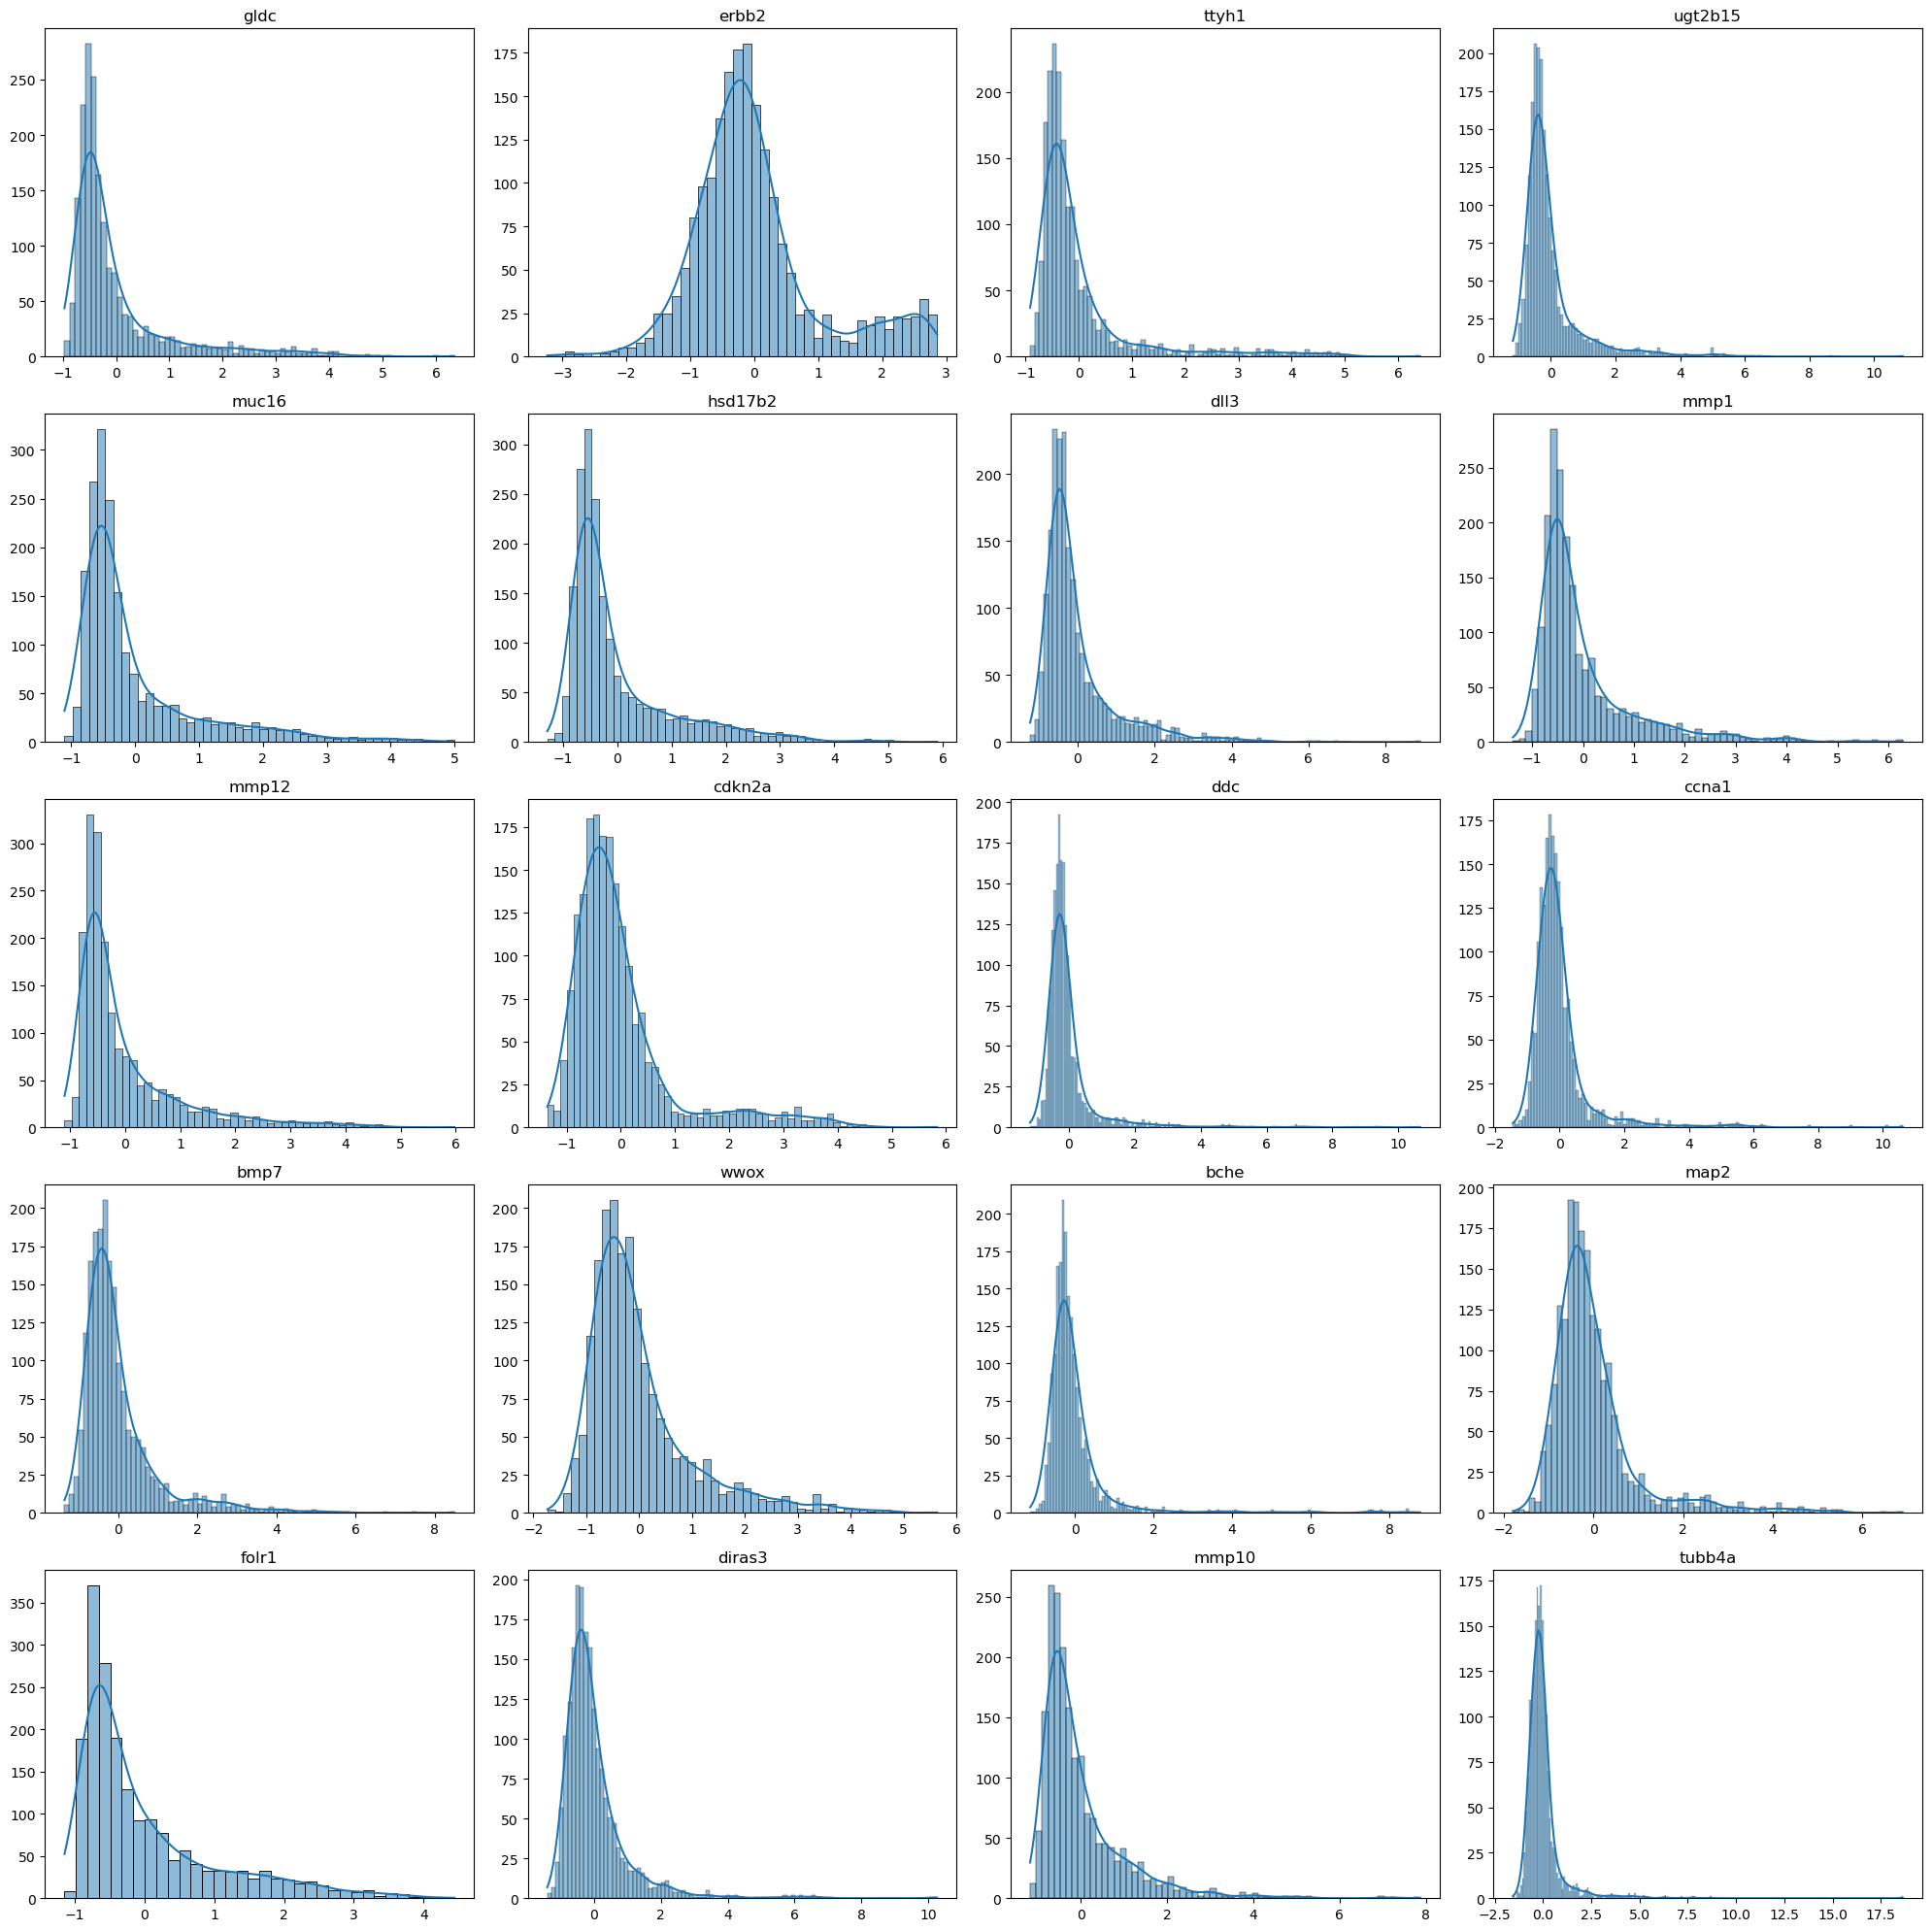

In [21]:
# there is some outliner and visualize this in histrogram
list_out_col = list(outlier_summary_sorted.items())[:20]
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
axes = axes.flatten()
for i, (col, _) in enumerate(list_out_col):
    sns.histplot(seconday_features_numerical[col], ax=axes[i], kde=True)
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
plt.tight_layout()
plt.show()

In [22]:
# most of them have outliner and have to level them to reduce the outliner effect
# cube square to avoid outliner effect
# gather all the columns with outliner then perform the cube square
top_outlier_columns = []
for col, num in list(outlier_summary_sorted.items()):
    if num > 10:
        top_outlier_columns.append(col)

for col in top_outlier_columns:
    seconday_features_numerical[f'{col}'] = np.cbrt(seconday_features_numerical[col])
seconday_features_numerical

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
0,-1.118423,-0.830973,-1.174871,1.132476,0.704998,1.048206,0.326478,0.502124,-0.942076,-0.950157,...,-1.059015,-0.268698,-1.177954,-0.598329,-0.829037,-1.054957,-1.139065,-0.841272,-0.959987,-0.694791
1,-1.113336,0.652417,-1.067185,0.809064,-0.238700,-0.643042,1.107768,0.926807,0.815279,-1.376108,...,-0.761282,0.768235,0.740959,0.913939,0.284805,0.969797,-0.984357,-0.609480,0.814225,-0.962620
2,0.406156,-0.944511,0.595710,-0.692852,0.801092,-0.431425,1.044582,0.748114,-0.738643,-1.041734,...,-0.813369,0.405751,0.941438,1.198772,0.738278,-1.549073,-1.158240,1.110667,-0.475926,0.714983
3,0.876946,-0.815730,-1.183858,0.860381,1.186610,-0.961179,1.076958,-1.059372,-0.747338,-0.851094,...,-0.825726,-0.891190,0.937055,0.880184,-0.579689,-1.325455,-0.997461,-0.680698,0.614463,-0.784493
4,1.089487,-0.966882,-0.897069,0.600741,0.703654,0.730427,0.970151,0.978055,0.915573,-0.664939,...,-0.836106,-0.707671,-1.004975,1.319260,0.566395,-0.539698,0.349522,1.710523,1.566980,1.097598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,0.538667,0.821451,-0.850357,0.770375,1.113927,-0.377275,-0.509552,0.657082,-0.417168,-0.819321,...,0.922831,1.152396,1.038376,0.932783,0.457570,-1.081338,-0.709133,-0.639476,-0.860470,-0.821303
1900,0.512106,0.970045,1.091868,0.903811,0.568876,0.140950,0.499063,1.301379,-0.852243,-0.953945,...,-0.808962,-0.871098,-0.544011,0.608310,0.800365,-0.698773,-1.022905,-0.885785,0.400208,-0.960566
1901,1.218846,-0.638904,0.737174,-0.668315,0.328963,-0.545136,1.156946,1.152521,-1.109369,-0.632386,...,-0.526203,-0.803836,1.338271,0.839525,-0.952550,-1.106327,-1.218150,-0.568774,0.458996,-0.855626
1902,-1.084238,-1.209531,-0.701629,-0.727478,0.874555,1.132657,1.030901,-0.455970,-0.852151,-1.248628,...,-0.860875,-1.151668,1.034466,0.603132,1.127070,-0.887269,-0.845583,-0.789177,-0.657854,-0.929901


In [23]:
# convert the main categorical data to one_hot_encoding
categorical_data = pd.get_dummies(categorical_data, columns=categorical_data.columns)

In [24]:
# third data separate
# convert the third data to one_hot_encoding
third_data = data[data.columns[519:]]
third_categorical_data = pd.get_dummies(third_data, columns=third_data.columns)

Model training and accuracy measure function

In [25]:

def train_and_evaluate_model(features, labels, model, model_name):
    # Step 1: Split the data into training and testing sets
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Step 2: Train the model
    model.fit(features_train, labels_train)

    # Step 3: Predict on the test set and calculate scores
    labels_pred = model.predict(features_test)
    labels_test = labels_test.ravel()
    labels_pred = labels_pred.ravel()
    labels_bin = label_binarize(labels_test, classes=np.unique(labels))
    f1 = f1_score(labels_test, labels_pred, average='weighted')
    roc_auc = roc_auc_score(labels_bin, model.predict_proba(features_test), average='weighted', multi_class='ovr')

    print(f"***********************{model_name}**********************")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

    fpr, tpr, _ = roc_curve(labels_bin[:, 1], model.predict_proba(features_test)[:, 1])
    roc_auc = roc_auc_score(labels_bin[:, 1], model.predict_proba(features_test)[:, 1])
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


knn_model = KNeighborsClassifier()             # K-Nearest Neighbors (KNN)
svm_model = SVC(probability=True)                  # Support Vector Machine (SVM)
logreg_model = LogisticRegression(max_iter=1000)     # Logistic Regression
rf_model = RandomForestClassifier(random_state=42)      # Random Forest

Training with only main_features

features = categorical_data + numerical_data

output = data_label

In [26]:
first_features = categorical_data.join(numerical_data)
train_and_evaluate_model(first_features, data_label, knn_model, 'KNN Model')
train_and_evaluate_model(first_features, data_label, svm_model, 'Support Vector Machine Model')
train_and_evaluate_model(first_features, data_label, logref_model, 'Logistic Regression')
train_and_evaluate_model(first_features, data_label, rf_model, 'Random Forest Classifer')

ValueError: y should be a 1d array, got an array of shape (381, 2) instead.

Training with only main_features and secondary_numerical_features 

features = categorical_features + numerical_features + secondary_features_numerical

output = data_label

Training with whole data

features = categorical_features + numerical_features + secondary_features_numerical + third_categorical_data

output = data_label